# Kütüphaneler

In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim  
import torchvision.transforms as transforms 
import torchvision
import os
import pandas as pd
from torch.utils.data import (Dataset,DataLoader) 
from skimage import io
import time

import warnings
warnings.filterwarnings("ignore")

# Veriyi Dahil Etme

In [2]:
class veri(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

# Veri Arttırma

In [3]:
dataset = veri(
    csv_file="f111.csv",
    root_dir=r"C:\Users\yasar\Desktop\f1_classification",
    transform=torchvision.transforms.Compose([transforms.ToTensor(),
                                              transforms.Resize(size=(28*28)),
                                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

# Veri Ön İşleme

In [4]:
train_set, test_set = torch.utils.data.random_split(dataset, [200, 79])
train_loader = DataLoader(dataset=train_set, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=True)

# Veriyi Görselleştirme

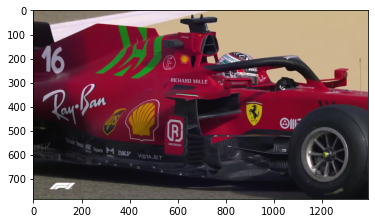

Ferrari
torch.Size([1, 3, 784, 1393])


In [5]:
import matplotlib.pyplot as plt
import numpy as np
batch_size=1
classes=["Ferrari","Mclaren","Mercedes","Redbull"]

def imshow(img):
    img = img / 2 + 0.5   
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
print(images.size())

# Model Mimarisi

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=4,kernel_size=(5,5))
        self.conv2=nn.Conv2d(in_channels=4,out_channels=8,kernel_size=(3,3))
        self.conv3=nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(2,2))#22
        self.conv4=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(2,2))#10
        
        self.max=nn.MaxPool2d(kernel_size=(2,2))
        self.func=nn.ELU()
        
        self.fc1=nn.Linear(in_features=519840,out_features=50)
        #self.fc1=nn.Linear(in_features=32*100*100,out_features=50)
        self.fc2=nn.Linear(in_features=50,out_features=50)
        self.fc3=nn.Linear(in_features=50,out_features=100)
        self.fc4=nn.Linear(in_features=100,out_features=4)
        
    def forward(self,x):
        
        x=self.conv1(x)
        x=self.func(x)
        
        x=self.max(x)
        
        x=self.conv2(x)
        x=self.func(x)
        
        x=self.max(x)
        
        x=self.conv3(x)
        x=self.func(x)
        
        x=self.max(x)
        
        x=self.conv4(x)
        x=self.func(x)

        #x=x.view(x.size(0), -1)
        x = x.view(x.size(0),519840) 
        
        x=self.fc1(x)
        x=self.func(x)
        x=self.fc2(x)
        x=self.func(x)
        x=self.fc3(x)
        x=self.func(x)
        x=self.fc4(x)
        return x        

# Modelin Eğitimi ve Doğruluğu

In [7]:
start=time.time()

device=torch.device("cuda")
model=Net()

optimizer=torch.optim.Adam(model.parameters(),lr=0.001)#0.00001 ilk
error=torch.nn.CrossEntropyLoss()

epoch=1
count = 0
loss_list = []
iteration_list = []
for i in range(epoch):
    for i,(images,label) in enumerate(train_loader):
        
        #images=images.to(device)
        #label=label.to(device)
        
        out=model(images)
        
        optimizer.zero_grad()
        
        loss=error(out,label)
        
        loss.backward()
        
        optimizer.step()  
        count+=1
        
        if count % 50 == 0:
            total=0
            correct=0
            correct_hata=0
            
            for images,labels in test_loader:
        
                out=model(images.float())
                
                y_pred=torch.max(out.data,1)[1]
                
                total+=len(labels)
                
                correct += (y_pred == labels).sum()
                correct_hata += (y_pred != labels).sum()
            
            accuracy = 100 * correct / float(total)
            hata = 100 * correct_hata / float(total)
            
            loss_list.append(loss.data)
            iteration_list.append(count)
        if count % 50 == 0:
            print('Iteration: {}  Loss: {}  Accuracy: {}% Error: {}%'.format(count, loss.data, accuracy,hata))

end=time.time()
print("Süre:",end-start)

Iteration: 50  Loss: 1.7110170125961304  Accuracy: 25.316455841064453% Error: 74.68354797363281%
Iteration: 100  Loss: 0.6640952229499817  Accuracy: 26.582279205322266% Error: 73.417724609375%
Iteration: 150  Loss: 3.0487470626831055  Accuracy: 30.37974739074707% Error: 69.62025451660156%
Iteration: 200  Loss: 0.968453586101532  Accuracy: 22.78481101989746% Error: 77.2151870727539%
Süre: 224.18438911437988
